In [161]:
# Commands for notebook to reload library files
%load_ext autoreload
%autoreload 2

# Add src folder as a module to import library code
import sys, os; sys.path.append(os.path.abspath(os.path.join(os.pardir, "src")))


# Models and analytical tools
import torch
from transformers import AutoTokenizer, EsmForProteinFolding

import numpy as np
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity

# Dimentionality reduction tools
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#  Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Local libraries
import lib.analysis as als
import lib.plot as plot
import lib.utils as utils

# Reload cached libraries
import importlib
importlib.reload(als)
importlib.reload(plot)
importlib.reload(utils)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'lib.utils' from '/Users/sofar03/Code/python/protein-structural-similarity/src/lib/utils.py'>

In [13]:
import os
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

In [73]:
protein_dir = os.environ.get('PROTEIN_DB_PATH', default=os.path.abspath(os.path.join(os.pardir, "protein_db")))
protein_dir

'/Users/sofar03/Code/python/protein-structural-similarity/protein_db'

In [27]:
device = torch.device("cpu")
print(device)

cpu


## ESM Model

In [3]:
def tokenize(input):
    tokenizer = AutoTokenizer.from_pretrained("facebook/esmfold_v1")
    return tokenizer(input, return_tensors="pt", add_special_tokens=False).to(device)

In [28]:
model = EsmForProteinFolding.from_pretrained("facebook/esmfold_v1").to(device)

Some weights of EsmForProteinFolding were not initialized from the model checkpoint at facebook/esmfold_v1 and are newly initialized: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
print(model)

EsmForProteinFolding(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 2560, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 2560, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-35): 36 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=2560, out_features=2560, bias=True)
              (key): Linear(in_features=2560, out_features=2560, bias=True)
              (value): Linear(in_features=2560, out_features=2560, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=2560, out_features=2560, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((2560,), eps=1

#### Max model parameters

In [45]:
with torch.no_grad():
    with open("model_parameters_max.txt", "w") as f:
        for p in model.named_parameters():
            layer_name = p[0]
            layer_values = p[1].numpy()
            max_value_idx = np.unravel_index(np.argmax(layer_values), layer_values.shape)
            max_value = layer_values[max_value_idx]
            f.write(f'Max value of layer {layer_name} at index {max_value_idx}: {max_value}')
            f.write('\n')

#### Min model parameters

In [48]:
with torch.no_grad():
    with open("model_parameters_min.txt", "w") as f:
        for p in model.named_parameters():
            layer_name = p[0]
            layer_values = p[1].numpy()
            min_value_idx = np.unravel_index(np.argmin(layer_values), layer_values.shape)
            min_value = layer_values[min_value_idx]
            f.write(f'Min value of layer {layer_name} at index {min_value_idx}: {min_value}')
            f.write('\n')

### Protein 1

In [53]:
# >1F7D_1|Chains A, B|POL POLYPROTEIN|Feline immunodeficiency virus (11673)
# seq1 = ["MIIEGDGILDKRSEDAGYDLLAAKEIHLLPGEVKVIPTGVKLMLPKGYWGLIIGKSSIGSKGLDVLGGVIDEGYRGEIGVIMINVSRKSITLMERQKIAQLIILPCKHEVLEQGKVVMDSERGDNGYGSTGVFSSW"]
seq1_name = "1F7D_1"

# >1DBW_1|Chains A, B|TRANSCRIPTIONAL REGULATORY PROTEIN FIXJ|Sinorhizobium meliloti (382)
seq1 = ["MQDYTVHIVDDEEPVRKSLAFMLTMNGFAVKMHQSAEAFLAFAPDVRNGVLVTDLRMPDMSGVELLRNLGDLKINIPSIVITGHGDVPMAVEAMKAGAVDFIEKPFEDTVIIEAIERASEHLVALE"]
seq1_name = "1DBW_1"

# >5YCI_1|Chains A, B|Ancestral myoglobin aMbWb' of Basilosaurus relative (polyphyly)|Physeter catodon (9755)
# seq1 = ["GSHMGLSDGEWQLVLNIWGKVEADVAGHGQDVLIRLFKGHPETLEKFDKFKHLKTEAEMKASEDLKKHGNTVLTALGGILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISDAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGFQG"]
seq1_name = "5YCI_1"

input1 = tokenize(seq1).to(device)
input1["input_ids"].shape


torch.Size([1, 126])

### Protein 2

In [54]:
# >1QHO_1|Chain A|ALPHA-AMYLASE|Geobacillus stearothermophilus (1422)
# seq2 = ["SSSASVKGDVIYQIIIDRFYDGDTTNNNPAKSYGLYDPTKSKWKMYWGGDLEGVRQKLPYLKQLGVTTIWLSPVLDNLDTLAGTDNTGYHGYWTRDFKQIEEHFGNWTTFDTLVNDAHQNGIKVIVDFVPNHSTPFKANDSTFAEGGALYNNGTYMGNYFDDATKGYFHHNGDISNWDDRYEAQWKNFTDPAGFSLADLSQENGTIAQYLTDAAVQLVAHGADGLRIDAVKHFNSGFSKSLADKLYQKKDIFLVGEWYGDDPGTANHLEKVRYANNSGVNVLDFDLNTVIRNVFGTFTQTMYDLNNMVNQTGNEYKYKENLITFIDNHDMSRFLSVNSNKANLHQALAFILTSRGTPSIYYGTEQYMAGGNDPYNRGMMPAFDTTTTAFKEVSTLAGLRRNNAAIQYGTTTQRWINNDVYIYERKFFNDVVLVAINRNTQSSYSISGLQTALPNGSYADYLSGLLGGNGISVSNGSVASFTLAPGAVSVWQYSTSASAPQIGSVAPNMGIPGNVVTIDGKGFGTTQGTVTFGGVTATVKSWTSNRIEVYVPNMAAGLTDVKVTAGGVSSNLYSYNILSGTQTSVVFTVKSAPPTNLGDKIYLTGNIPELGNWSTDTSGAVNNAQGPLLAPNYPDWFYVFSVPAGKTIQFKFFIKRADGTIQWENGSNHVATTPTGATGNITVTWQN"]
# seq2_name = "1QHO_1"

# >2QWV_1|Chains A, B|UPF0217 protein VC_A1059|Vibrio cholerae O1 biovar eltor str. N16961 (243277)
seq2 = ["SNAMRNTMRSFILRARSAPTDSQRLLDEIGGKCHTEILAHCMMNSLFTAQSHREDVVIHLVLESTRDYSRTITVEANEISDVGGFHEAALIALLVKALDASVGMGKEQTRVVQPGLTVRTISFEALLGELAEHHSLYMMDKKGDSIRDIKIGPNPCFILTDHIPMPKKSGNSMKRLGVEKISLGPKMLFASQCVTLIHNEIDHQEAGW"]
seq2_name = "2QWV_1"

# >1AZI_1|Chain A|MYOGLOBIN|Equus caballus (9796)
# seq2 = ["GLSDGEWQQVLNVWGKVEADIAGHGQEVLIRLFTGHPETLEKFDKFKHLKTEAEMKASEDLKKHGTVVLTALGGILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISDAIIHVLHSKHPGDFGADAQGAMTKALELFRNDIAAKYKELGFQG"]
# seq2_name = "1AZI_1"

input2 = tokenize(seq2).to(device)
input2["input_ids"].shape

torch.Size([1, 208])

### Prott5 sample

In [ ]:
seqx = ["MGYINVFAFPFTIYSLLLCRMNSRNYIAQVDVVNFNLT"]
inputx = tokenize(seqx)
inputx

## Prediction

In [31]:
def predict(input):
    with torch.no_grad():
        return model(**input)

In [32]:
out1 = predict(input1)

In [33]:
out2 = predict(input2)

In [ ]:
outx = predict(inputx)

In [ ]:
with torch.no_grad():
    attention = torch.ones_like(input1['input_ids']).to(device)
    m_esm_a = model.af2_idx_to_esm_idx(input1['input_ids'], attention)
    m_esm_s = model.compute_language_model_representations(m_esm_a)

## Infer PDB

In [182]:
with torch.no_grad():
    pdb = model.infer_pdb(seq2[0])

In [24]:
with open(f'../pdb/{seq2_name}.pdb', "w") as f:
    f.write(pdb)

## Analysis

### From model

In [59]:
emb1 = out1['s_s'].cpu().numpy()
emb1 = np.squeeze(emb1, axis=0)

emb2 = out2['s_s'].cpu().numpy()
emb2 = np.squeeze(emb2, axis=0)

In [137]:
als.save(data=emb1, name=utils.embeddings_path(seq1_name, emb1.shape))
als.save(data=emb2, name=utils.embeddings_path(seq2_name, emb2.shape))

In [61]:
emb1.shape

(126, 1024)

In [62]:
emb2.shape

(208, 1024)

In [ ]:
embx = outx['s_s'].cpu().numpy()
embx = np.squeeze(embx, axis=0)

### From file

In [131]:
emb1 = utils.read_protein("5YCI_1")
emb2 = utils.read_protein("2QWV_1")

In [132]:
emb1.shape

(126, 1024)

In [133]:
emb2.shape

(208, 1024)

### Per-residue embeddings correlation

In [149]:
norm_emb1 = als.normalized_z_score(emb1)
norm_emb2 = als.normalized_z_score(emb2)

In [133]:
min_max_emb1 = np.array([als.remove_min_max(e, iterations=4) for e in emb1])
min_max_emb2 = np.array([als.remove_min_max(e, iterations=4) for e in emb2])

In [113]:
protein_corr = als.protein_correlation(emb1.T, emb2.T, window=10)

In [144]:
self_corr = als.protein_correlation(emb1.T, emb1.T, window=10)

In [114]:
norm_protein_corr = als.protein_correlation(norm_emb1.T, norm_emb2.T, window=10)

In [134]:
min_max_protein_corr = als.protein_correlation(min_max_emb1.T, min_max_emb2.T, window=10)

/Users/sofar03/Code/python/protein-structural-similarity/src/lib/analysis.py:11: RuntimeWarning: invalid value encountered in divide
  result = x / x.max(axis=1).reshape((x.shape[0], 1))


In [115]:
protein_corr.shape

(1024, 117, 199)

In [102]:
als.autocorr(emb1[:, 81], window=10, normalize=True).shape

(148, 10)

In [25]:
autocorr_emb1 = np.array([als.autocorr(e, normalize=True) for e in emb1.T]).squeeze(-2)
autocorr_emb2 = np.array([als.autocorr(e, normalize=True) for e in emb2.T]).squeeze(-2)

In [26]:
autocorr_norm_emb1 = np.array([als.autocorr(e, normalize=True) for e in norm_emb1.T]).squeeze(1)
autocorr_norm_emb2 = np.array([als.autocorr(e, normalize=True) for e in norm_emb2.T]).squeeze(1)

In [43]:
np.argmax(emb1[0])

274

## Plots

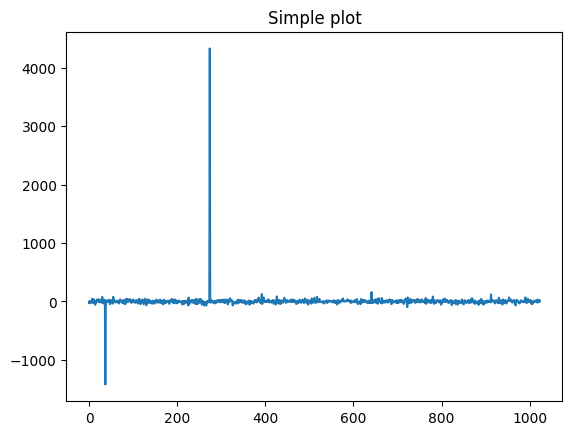

In [40]:
plot.simple_plot(emb1[0])

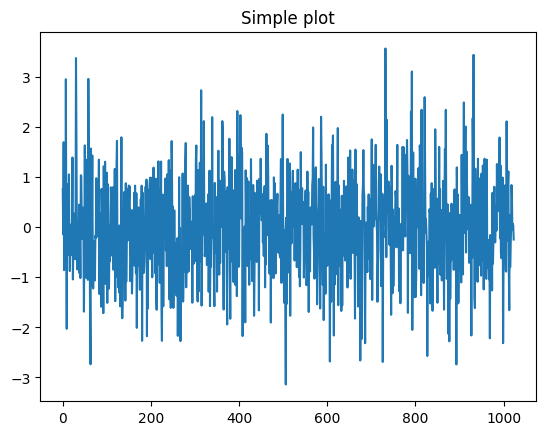

In [130]:
plot.simple_plot(norm_emb1[0])

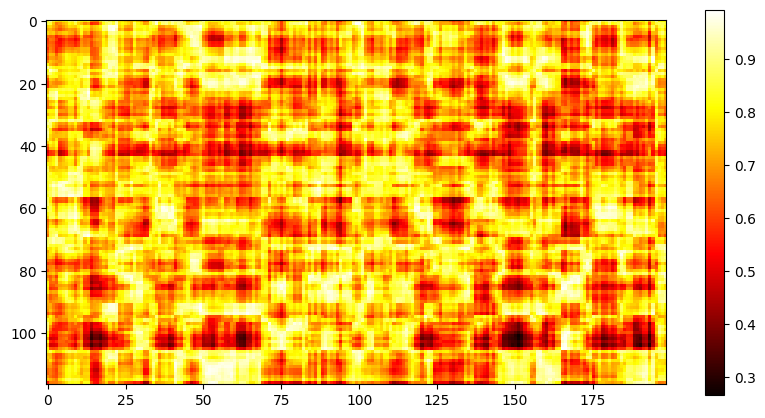

In [128]:
plot.heatmap2d(protein_corr[28])

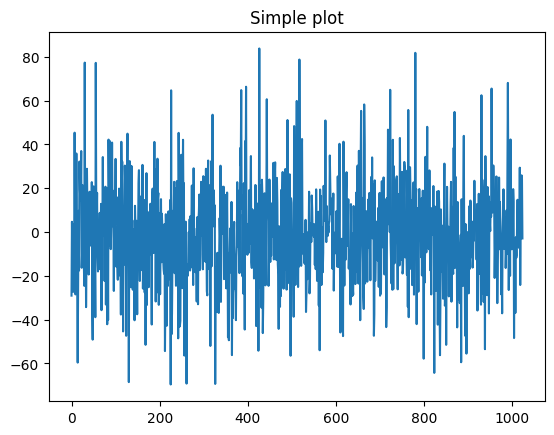

In [20]:
plot.simple_plot(min_max_emb1[0])

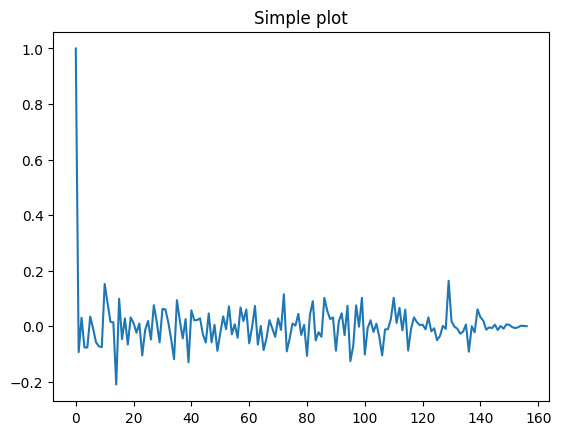

In [290]:
plot.simple_plot(als.autocorr(norm_emb1.T[31], normalize=True).squeeze(0))

In [53]:
protein_corr.shape

(1024, 144, 148)

In [142]:
test = np.min(protein_corr, axis=0)
test[test < 0.4] = 0

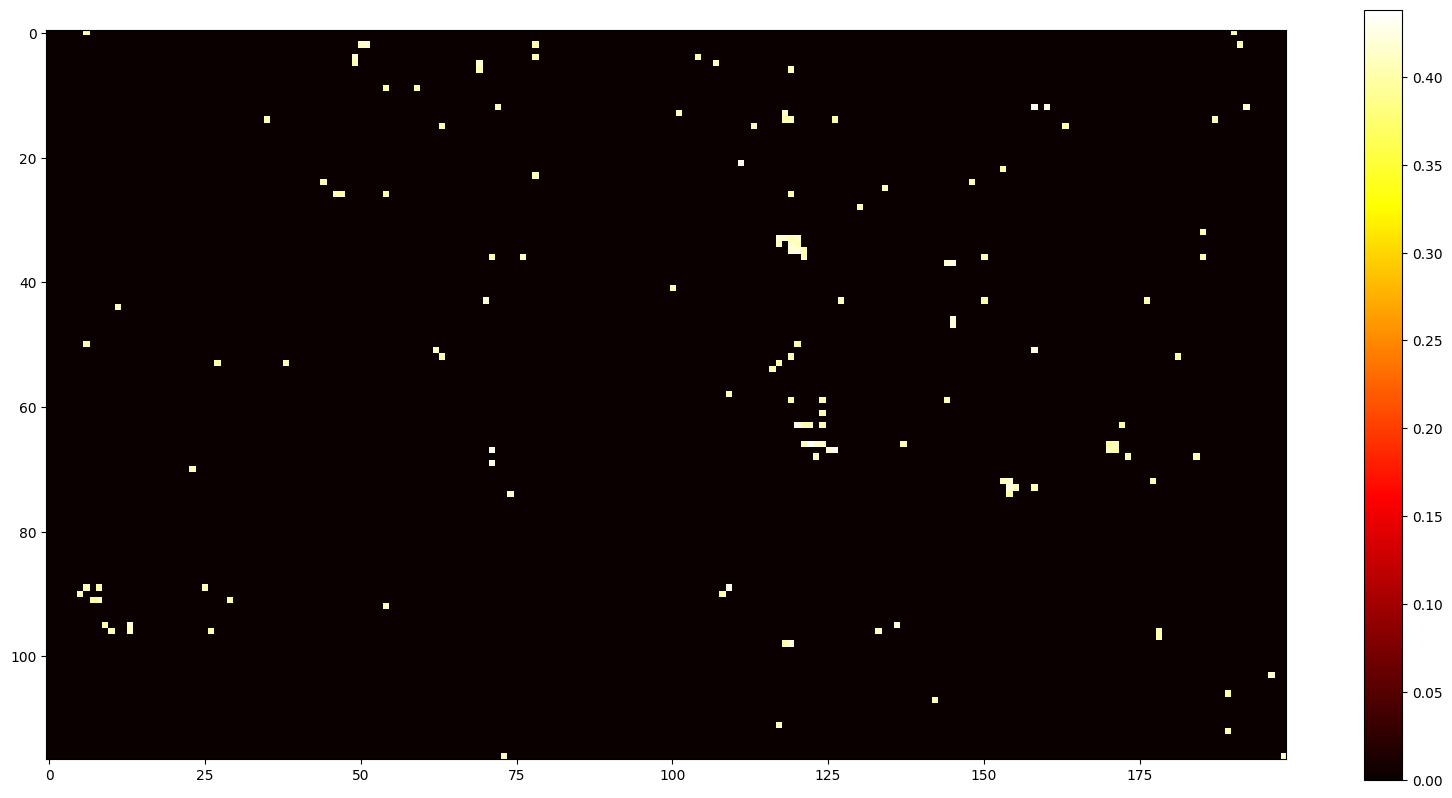

In [143]:
plot.heatmap2d(test, scale=2)

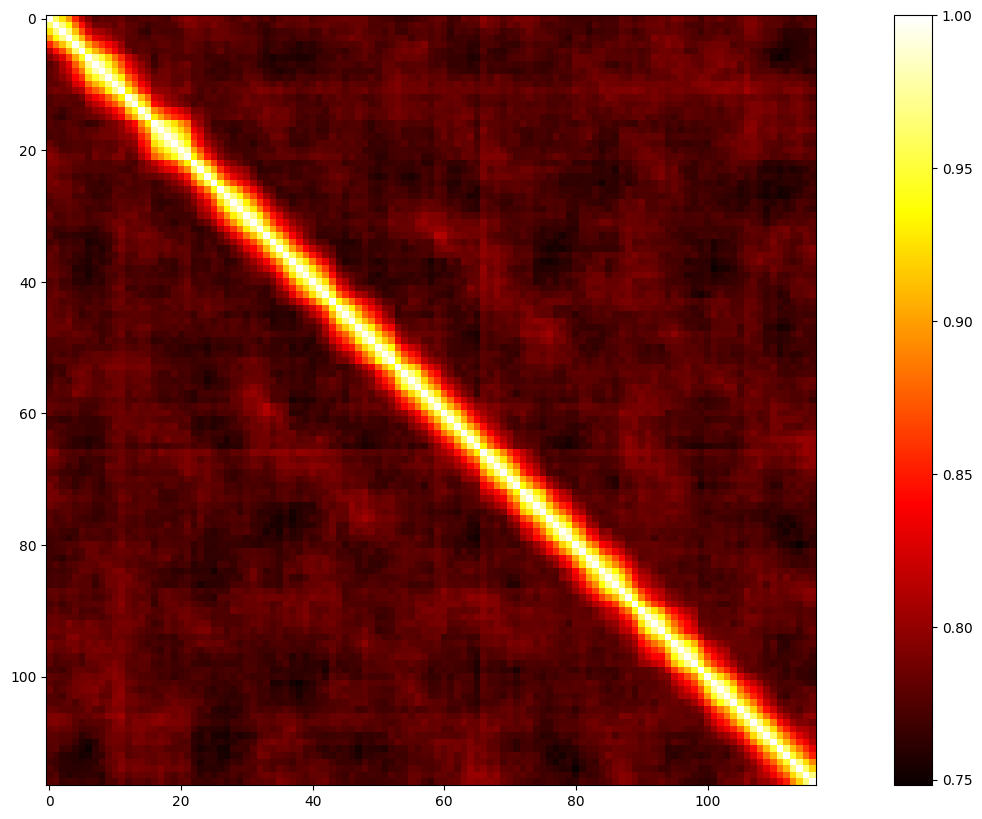

In [147]:
plot.heatmap2d(np.median(self_corr, axis=0), scale=2)

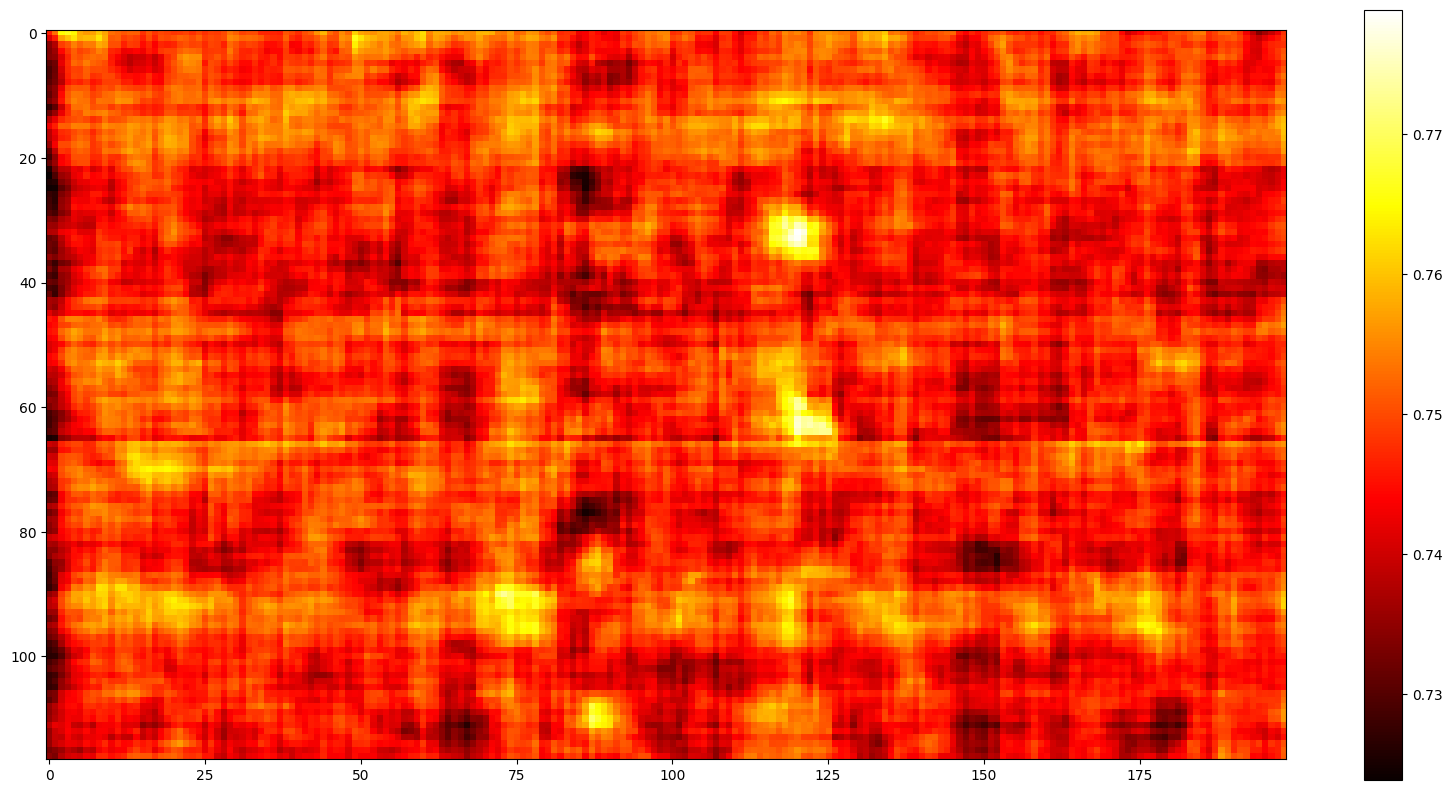

In [132]:
plot.heatmap2d(np.mean(norm_protein_corr, axis=0), scale=2)

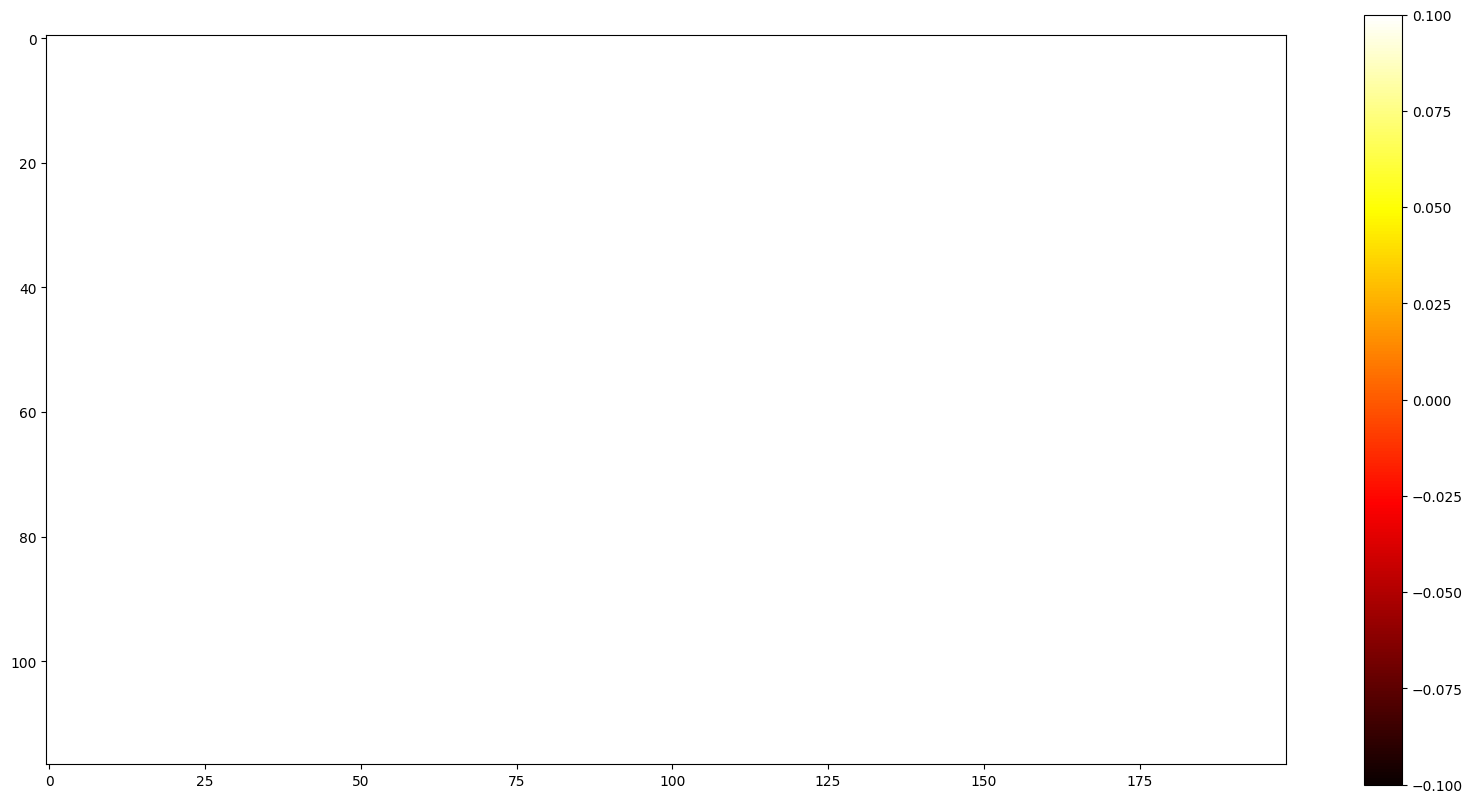

In [136]:
plot.heatmap2d(np.mean(min_max_protein_corr, axis=0), scale=2)

In [158]:
als.crosscorr(norm_emb1[7], norm_emb2[7]).shape

(1, 1024)

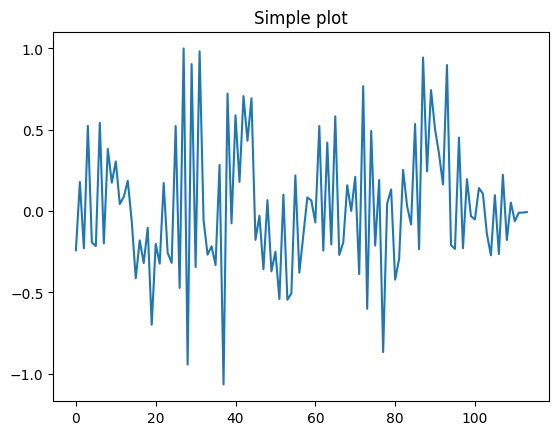

In [177]:
plot.simple_plot(als.crosscorr(emb1.T[0], emb2.T[0], window=20, normalize=True)[9])

In [161]:
cosine_similarity(norm_emb1[4].reshape(1, -1), norm_emb2[0].reshape(1, -1))

array([[0.6786132]], dtype=float32)

In [228]:
norm_emb1[:153].shape

(153, 1024)

In [137]:
cossim1 = cosine_similarity(norm_emb1)
cossim1[cossim1 < 0.4] = 0

cossim2 = cosine_similarity(norm_emb2)
cossim2[cossim2 < 0.4] = 0

cossim3 = cosine_similarity(min_max_emb1, min_max_emb2)
cossim3[cossim3 < 0.4] = 0

In [338]:
cosine_similarity(min_max_emb1[6].reshape(1, -1), min_max_emb2[2].reshape(1, -1))

array([[0.9705536]], dtype=float32)

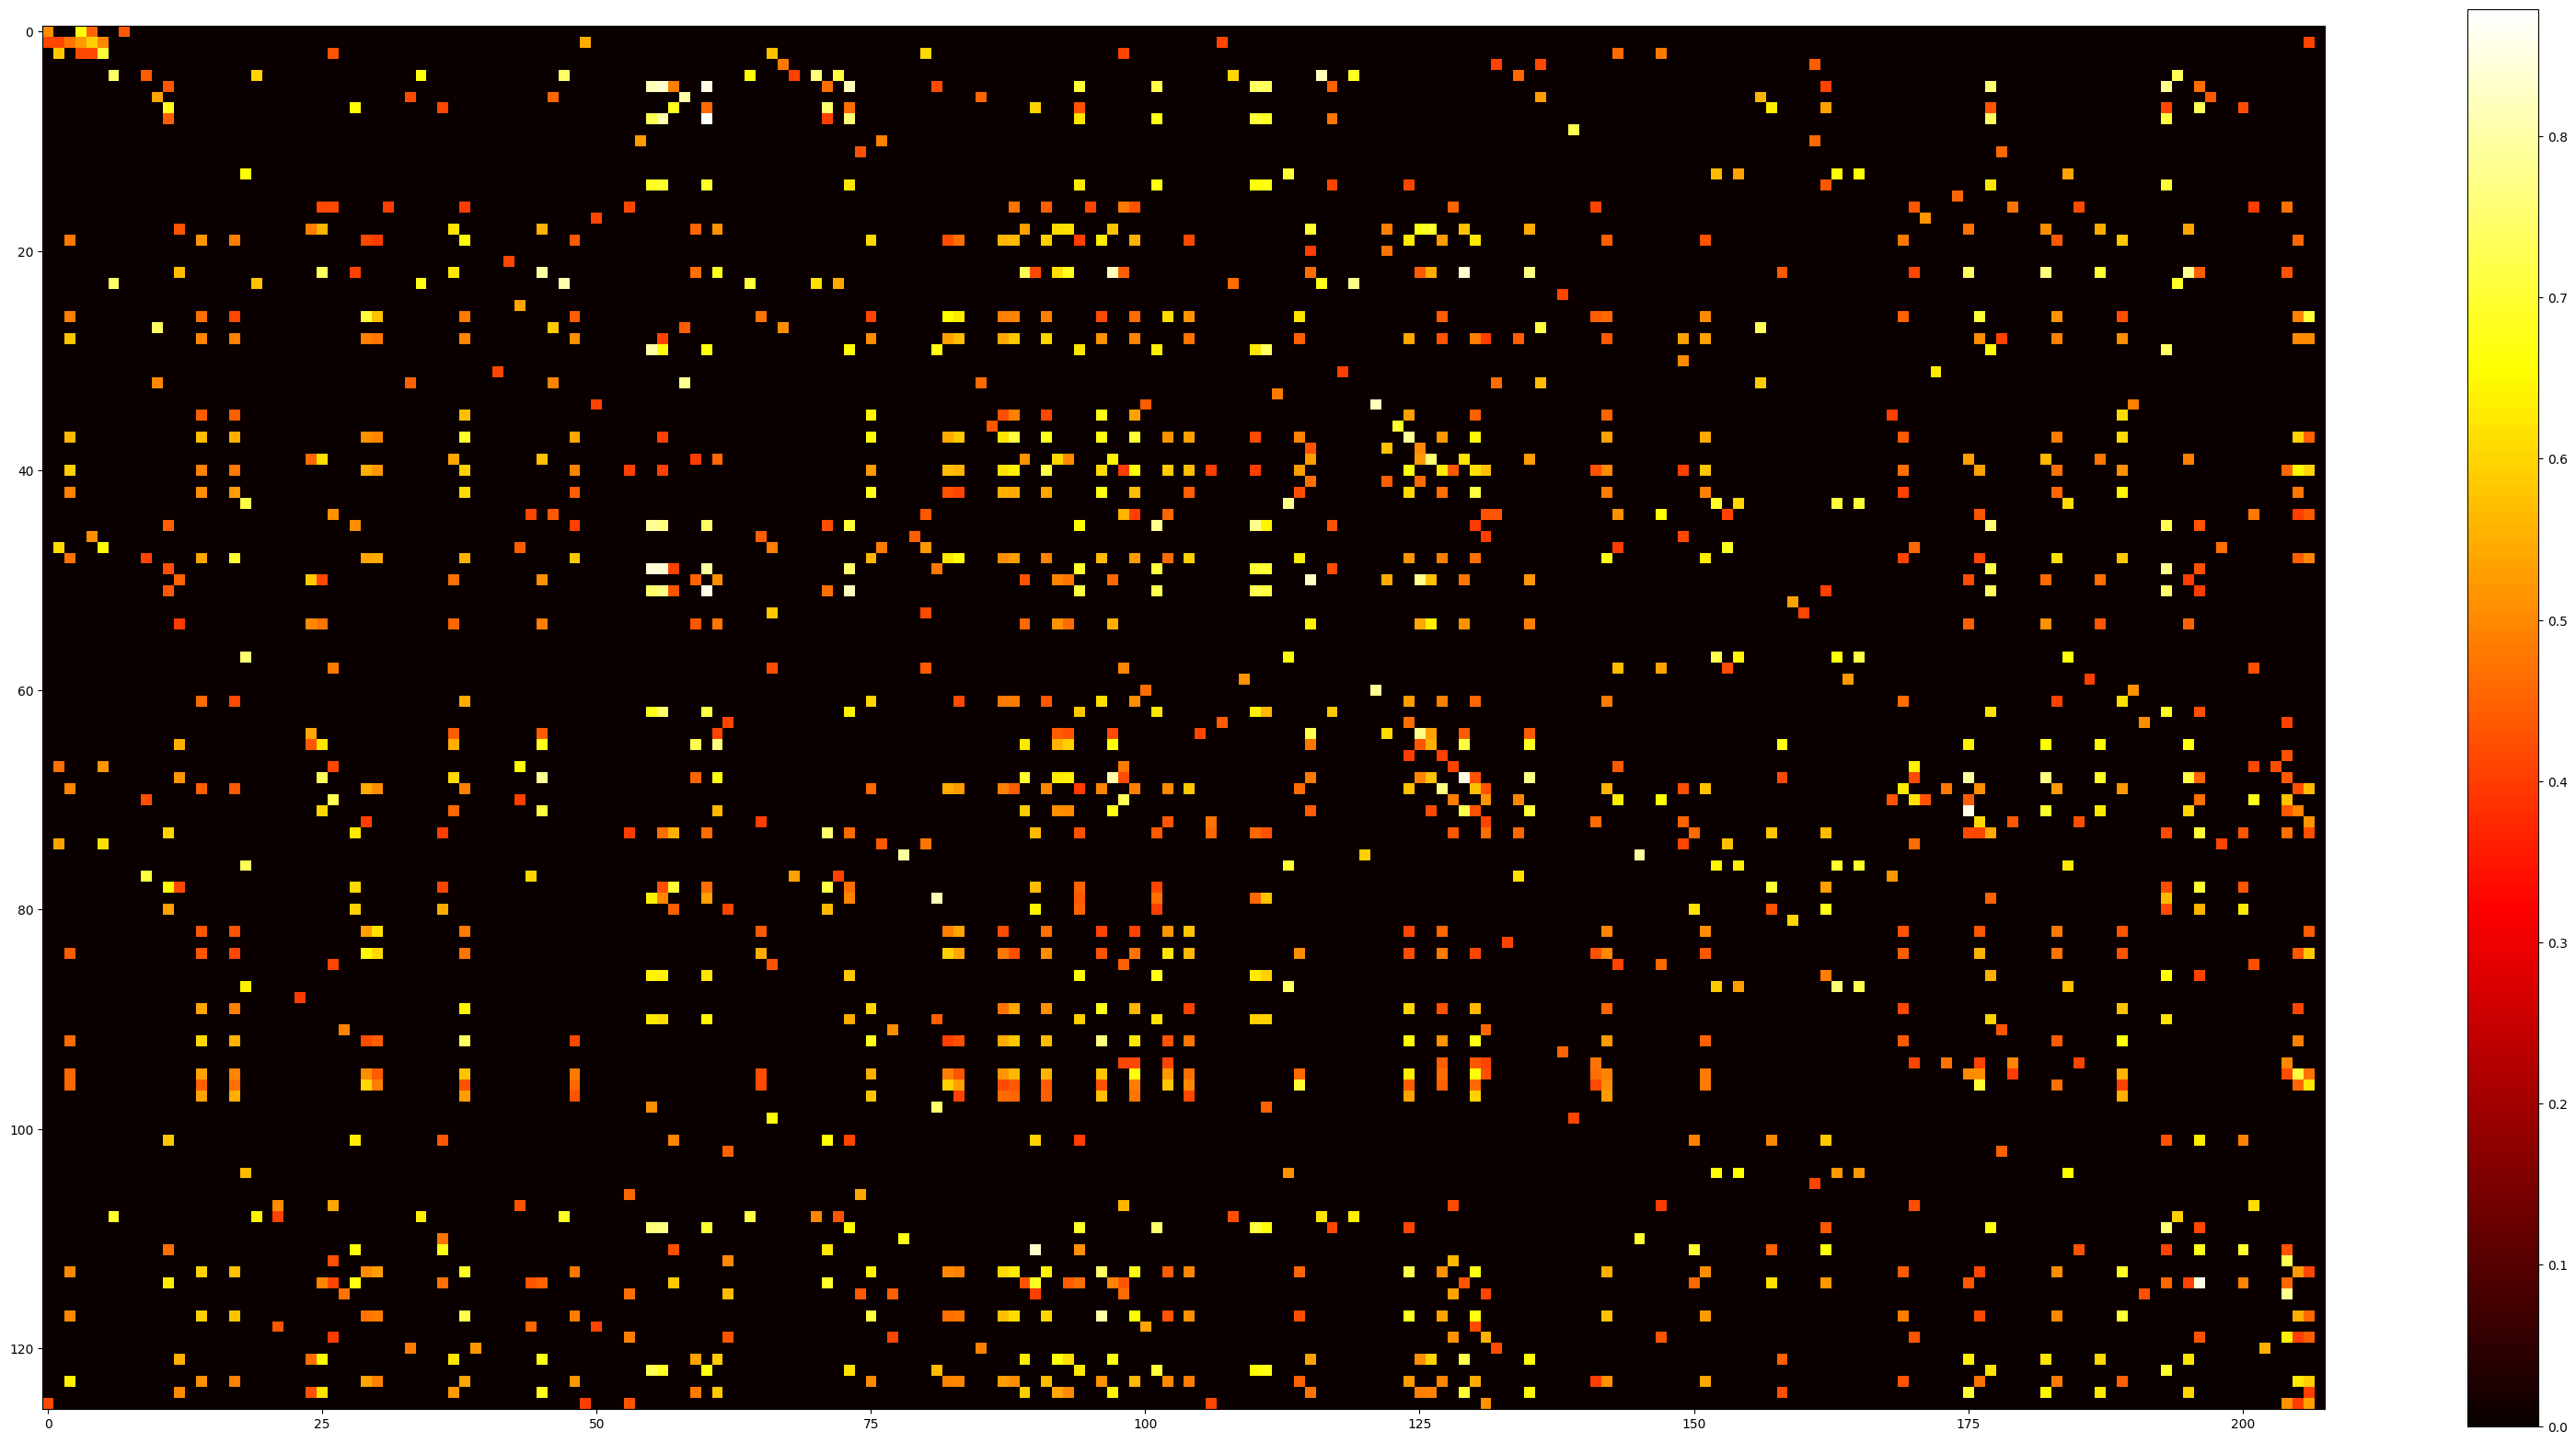

In [138]:
plot.heatmap2d(cossim3, scale=4)

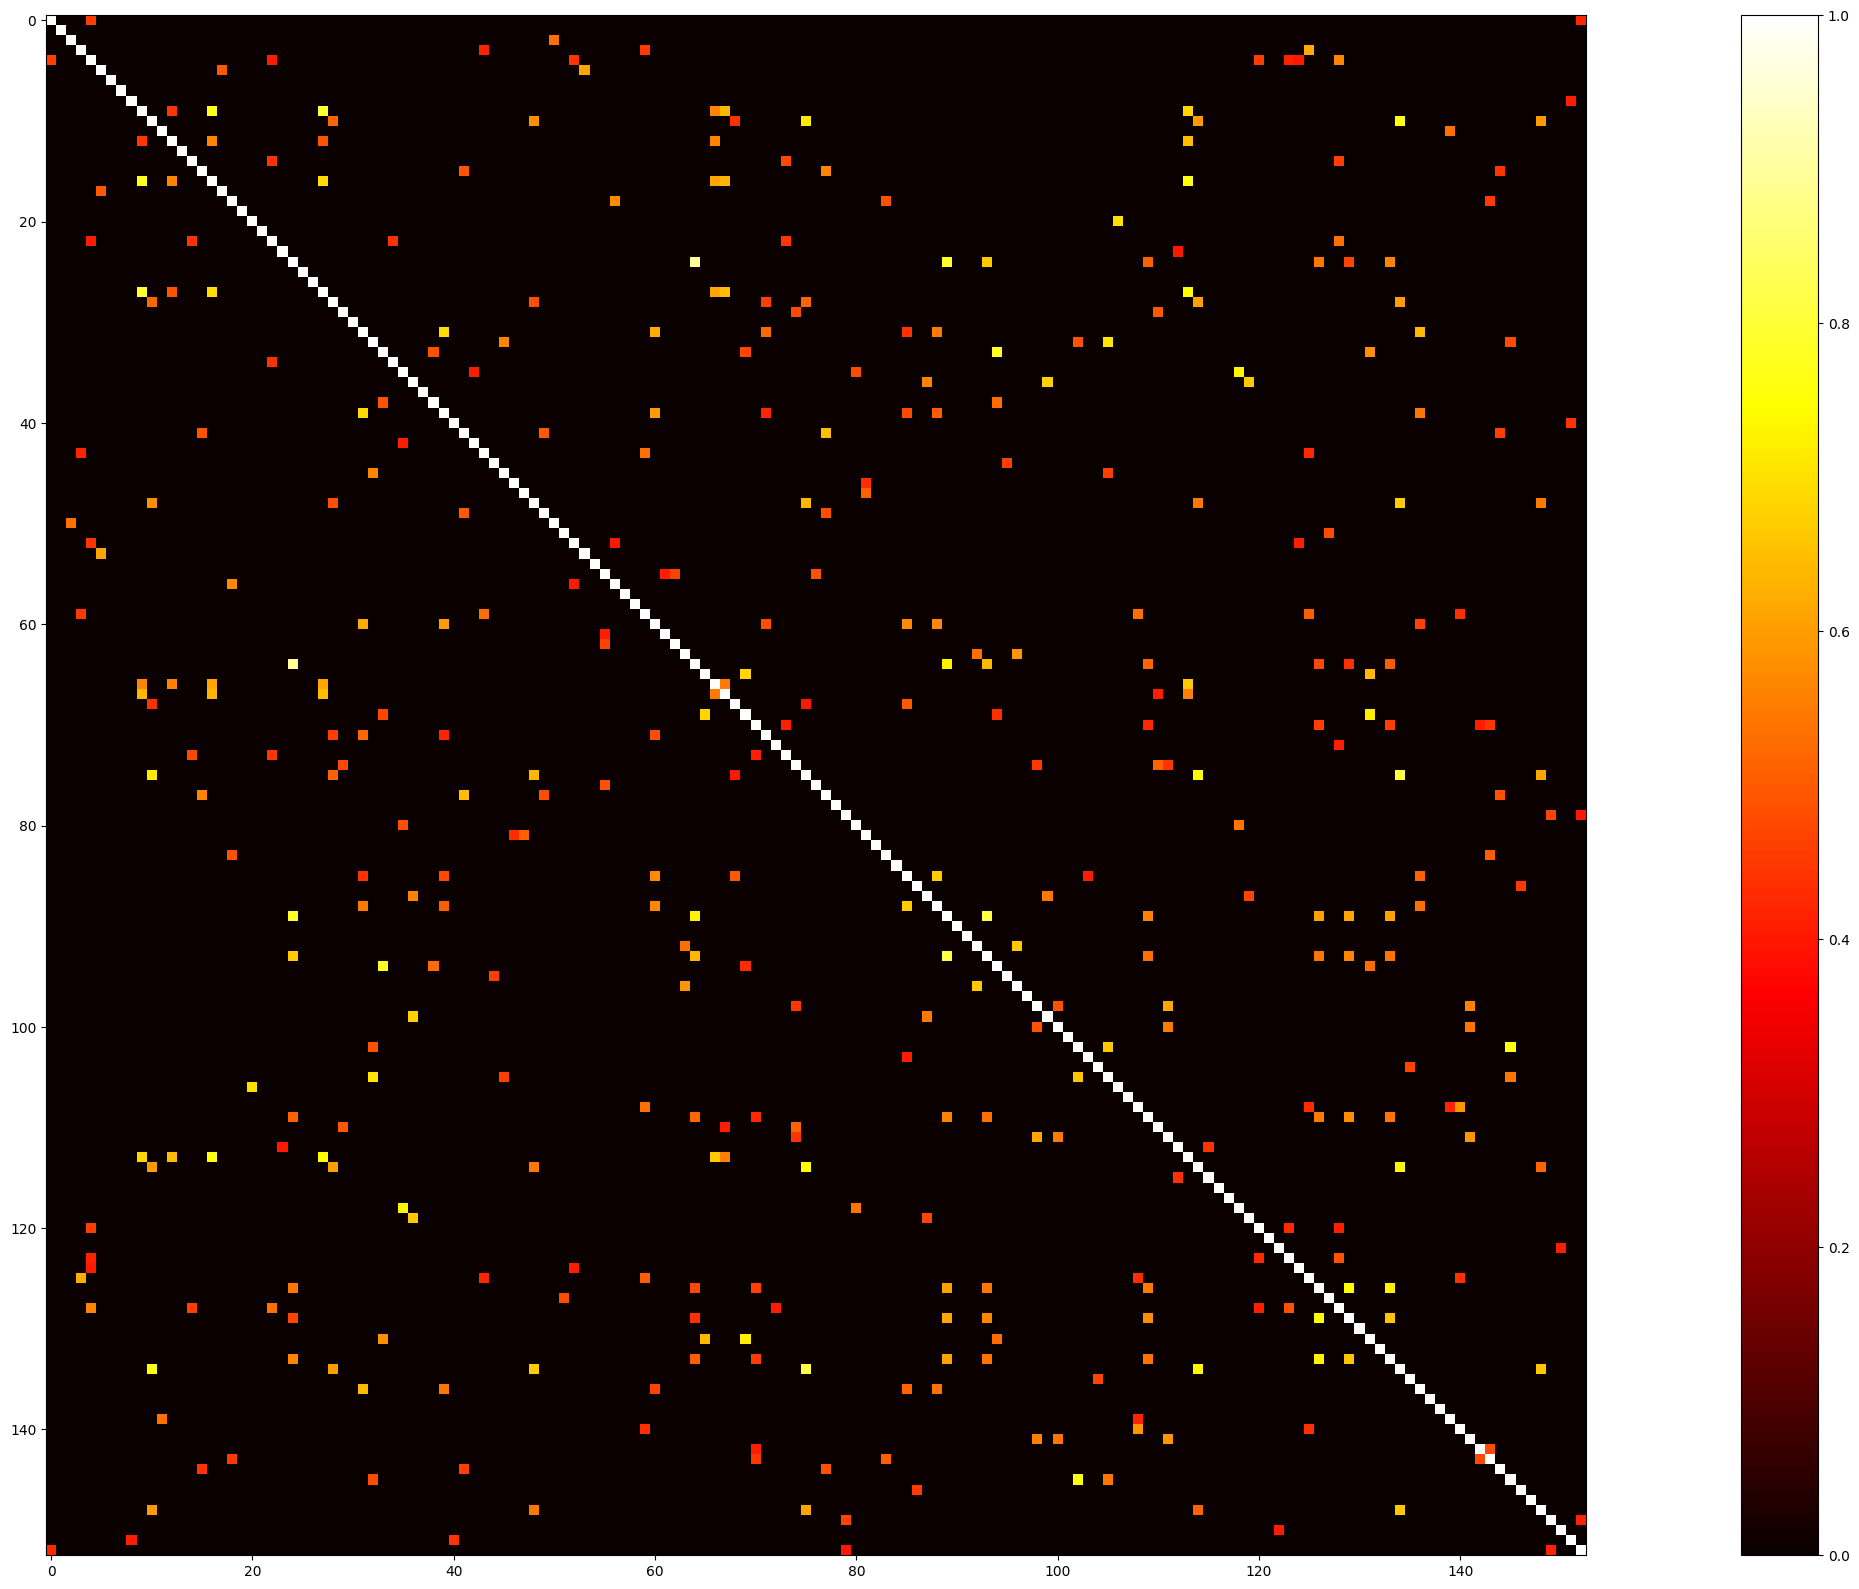

In [251]:
plot.heatmap2d(cossim2, scale=4)

## Pairwise residue embeddings analysis

In [34]:
pair_emb1 = out1['s_z'].cpu().numpy().squeeze(0)
pair_emb2 = out2['s_z'].cpu().numpy().squeeze(0)

In [81]:
als.save(data=pair_emb1.reshape(-1, pair_emb1.shape[2]), name=f'{protein_dir}/esm/embeddings/{seq1_name}/pair_{utils.shape_to_str(pair_emb1.shape)}.txt')
als.save(data=pair_emb2.reshape(-1, pair_emb1.shape[2]), name=f'{protein_dir}/esm/embeddings/{seq2_name}/pair_{utils.shape_to_str(pair_emb2.shape)}.txt')

### From file

In [128]:
pair_emb1 = utils.read_protein("5YCI_1", type="pair")
pair_emb2 = utils.read_protein("2QWV_1", type="pair")

In [129]:
pair_emb1.shape

(208, 208, 128)

In [130]:
pair_emb2.shape

(126, 126, 128)

## Plots

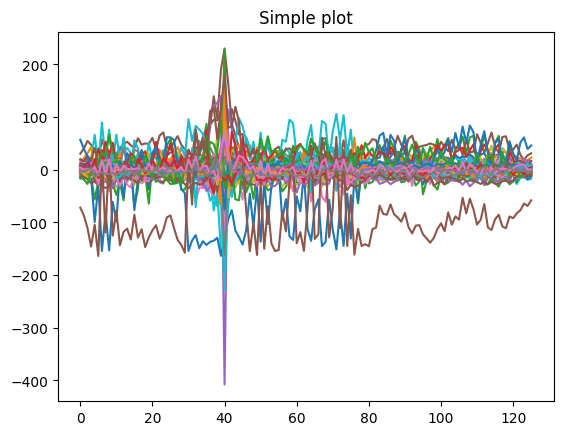

In [154]:
plot.simple_plot(pair_emb1[40])

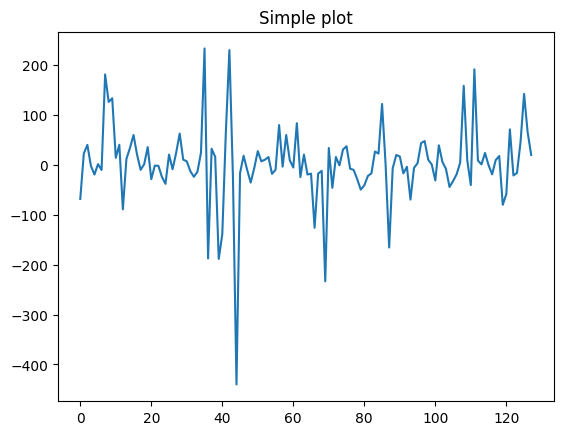

In [159]:
plot.simple_plot(pair_emb2[35][35])

In [179]:
pair_sim1 = np.mean(als.cossim3d(pair_emb1), axis=0)
pair_sim1[pair_sim1 < 0.5] = 0
pair_sim2 = np.mean(als.cossim3d(pair_emb2), axis=0)
pair_sim2[pair_sim2 < 0.5] = 0

In [180]:
pair_sim1[23]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.57460153,
       0.65863957, 0.78933483, 0.67024228, 0.88933365, 0.74708692,
       0.86351516, 0.74526867, 0.83272864, 1.        , 0.72513475,
       0.76113522, 0.83804665, 0.88189313, 0.70734308, 0.66810137,
       0.79579402, 0.77977873, 0.7771394 , 0.65213642, 0.71029112,
       0.63012492, 0.54454959, 0.51883245, 0.53990127, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.61666807, 0.62281549, 0.80232428, 0.76583056,
       0.80207736, 0.76284194, 0.67518049, 0.61465504, 0.62849496,
       0.        , 0.        , 0.        , 0.        , 0.     

In [181]:
pair_sim1[41]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.52066278, 0.        , 0.57147973,
       0.56885258, 0.54052074, 0.65895332, 0.        , 0.5732365 ,
       0.        , 0.        , 0.58642529, 0.        , 0.        ,
       0.        , 0.53150069, 0.        , 0.        , 0.60677215,
       0.        , 0.        , 0.        , 0.55115224, 0.        ,
       0.        , 0.        , 0.54028726, 0.50873262, 0.65760866,
       0.55680446, 0.5723541 , 0.77124159, 0.79448923, 0.62593427,
       0.74085868, 1.        , 0.72647683, 0.59733239, 0.74218671,
       0.79903992, 0.61403073, 0.50799717, 0.        , 0.        ,
       0.        , 0.61576122, 0.50621205, 0.        , 0.        ,
       0.60400066, 0.6141603 , 0.76622404, 0.61981545, 0.733742  ,
       0.53182308, 0.5706164 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.51216777,
       0.54340966, 0.68000629, 0.61734371, 0.79009858, 0.58761

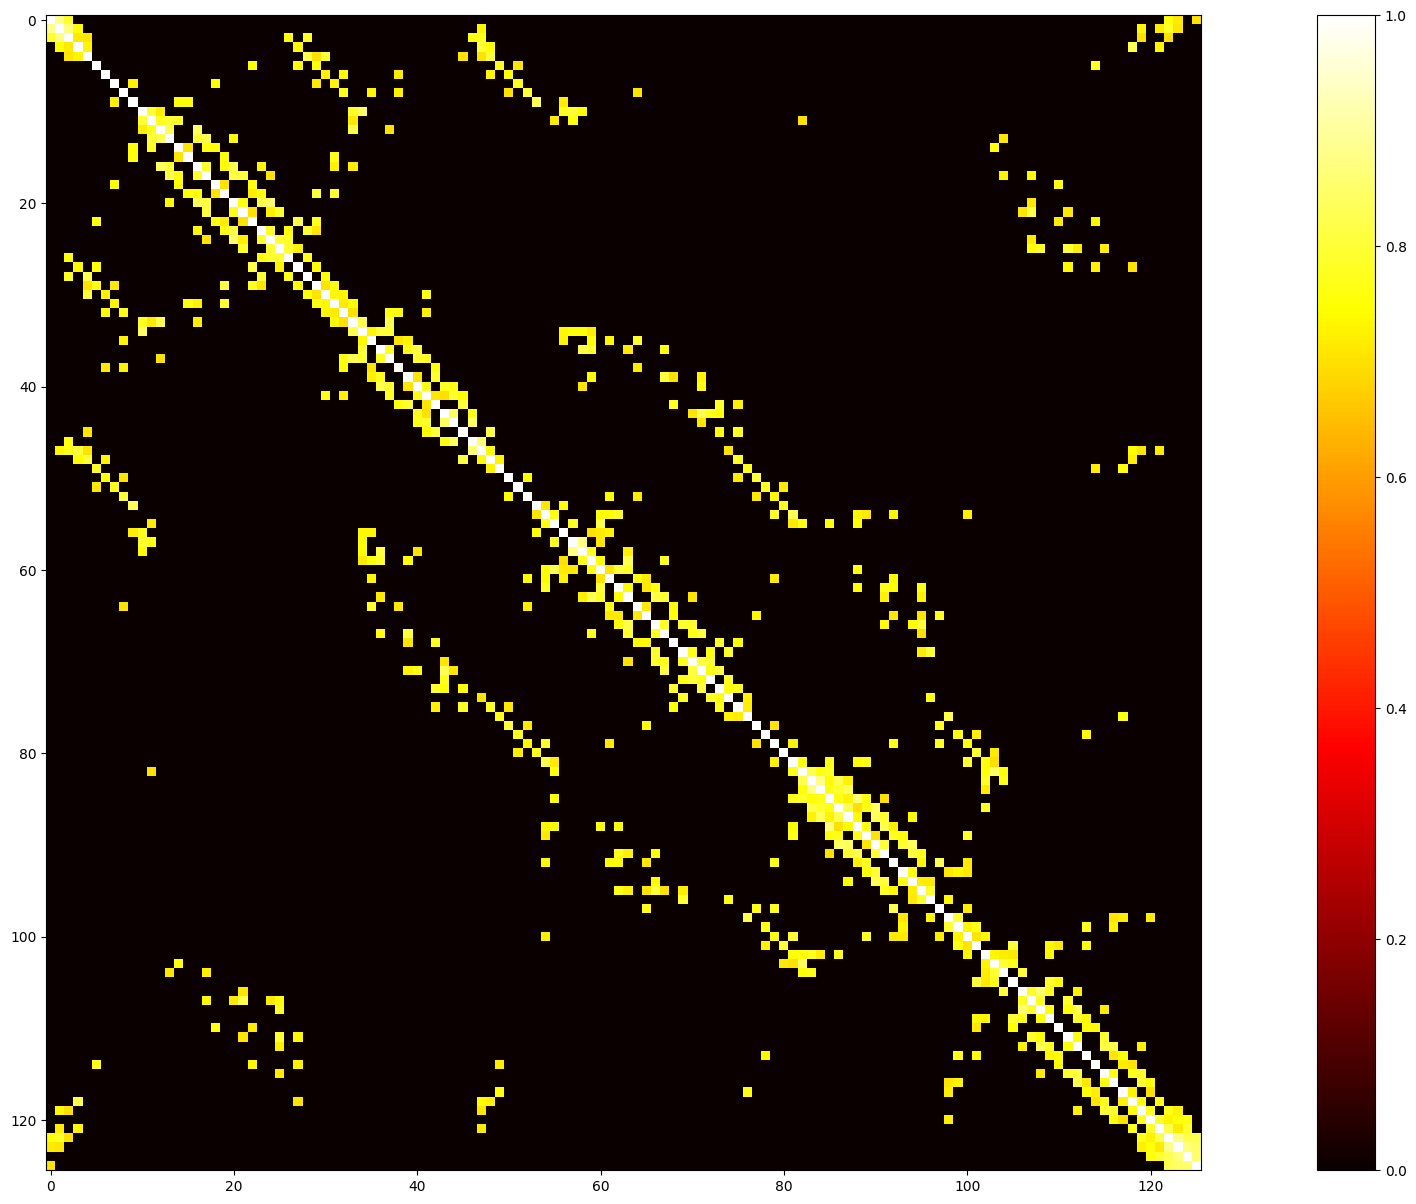

In [51]:
plot.heatmap2d(pair_sim1, scale=3)

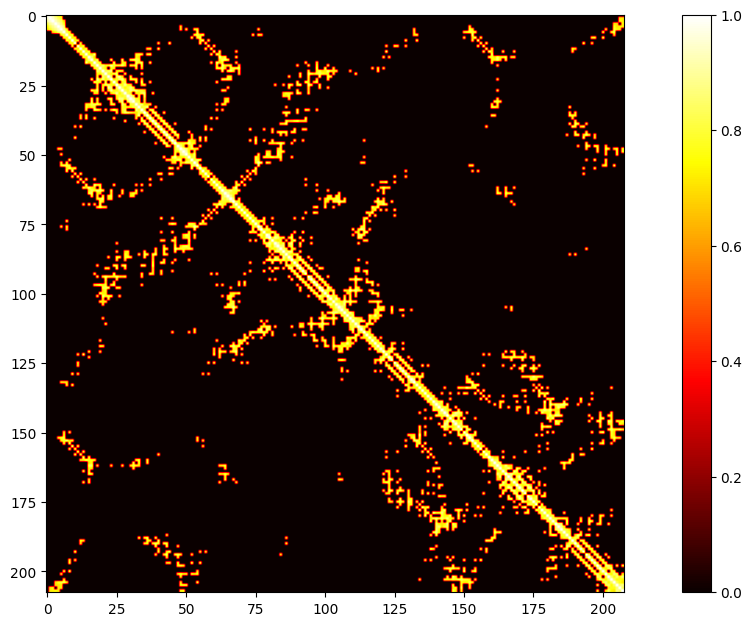

In [52]:
plot.heatmap2d(pair_sim2, scale=1.5)

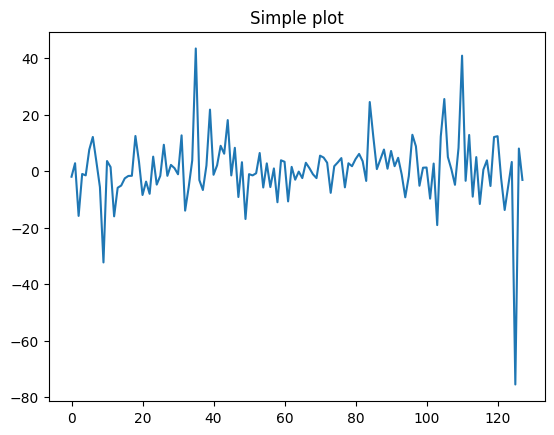

In [168]:
plot.simple_plot(pair_emb1[17, 0])

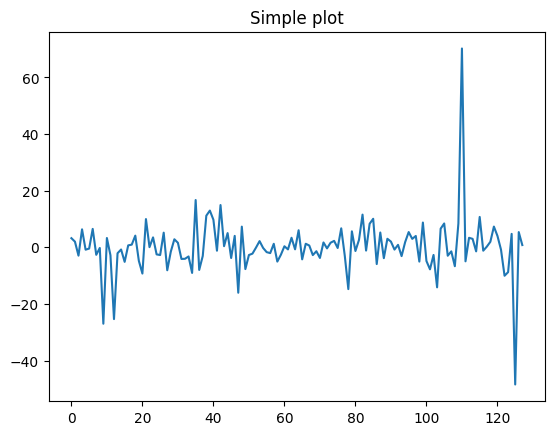

In [169]:
plot.simple_plot(pair_emb2[41, 0])

In [14]:
pair_emb1_dist = np.array([cosine_similarity(pair) for pair in pair_emb1])

In [15]:
pair_emb1_dist.shape

(126, 126, 126)

In [196]:
cosine_similarity(np.vstack((pair_emb1[23], pair_emb1[41])))

array([[1.        , 0.88474137, 0.79053897, ..., 0.45175004, 0.6293276 ,
        0.6139815 ],
       [0.88474137, 0.9999999 , 0.86997867, ..., 0.40177155, 0.5526417 ,
        0.500473  ],
       [0.79053897, 0.86997867, 1.        , ..., 0.24386837, 0.4295016 ,
        0.4559761 ],
       ...,
       [0.45175004, 0.40177155, 0.24386837, ..., 0.9999999 , 0.8198302 ,
        0.8181122 ],
       [0.6293276 , 0.5526417 , 0.4295016 , ..., 0.8198302 , 0.9999999 ,
        0.897701  ],
       [0.6139815 , 0.500473  , 0.4559761 , ..., 0.8181122 , 0.897701  ,
        0.99999976]], dtype=float32)

In [221]:
pair_emb1[17][17:26].shape

(9, 128)

In [230]:
als.slice_of_slice(pair_emb1, (17,26), (17,26)).reshape((-1, 128)).shape

(81, 128)

In [248]:
pair_emb2[44]

array([[ 3.1431592e-01,  1.4886618e-02, -9.0989488e-01, ...,
        -5.1292812e+01,  3.9891839e-01,  2.3552151e+00],
       [-2.6964195e+00, -3.9428093e+00, -3.8510251e+00, ...,
        -5.7865234e+01, -3.2129507e+00,  2.1853480e+00],
       [-1.4736079e+00, -5.3139753e+00,  1.4715836e+00, ...,
        -6.5764297e+01, -6.0238016e-01,  4.6974044e+00],
       ...,
       [-2.9497020e+00, -3.2468967e+00,  2.9990256e-01, ...,
        -1.2904073e+02, -6.1640954e+00,  2.8300648e+00],
       [ 7.2216043e+00, -4.4092360e+00, -3.6285539e+00, ...,
        -9.8983368e+01, -7.4064550e+00,  4.7528368e-01],
       [-4.2556520e+00,  8.5342818e-01,  9.4459906e-02, ...,
        -1.0328830e+02, -4.6593266e+00,  4.7037811e+00]], dtype=float32)

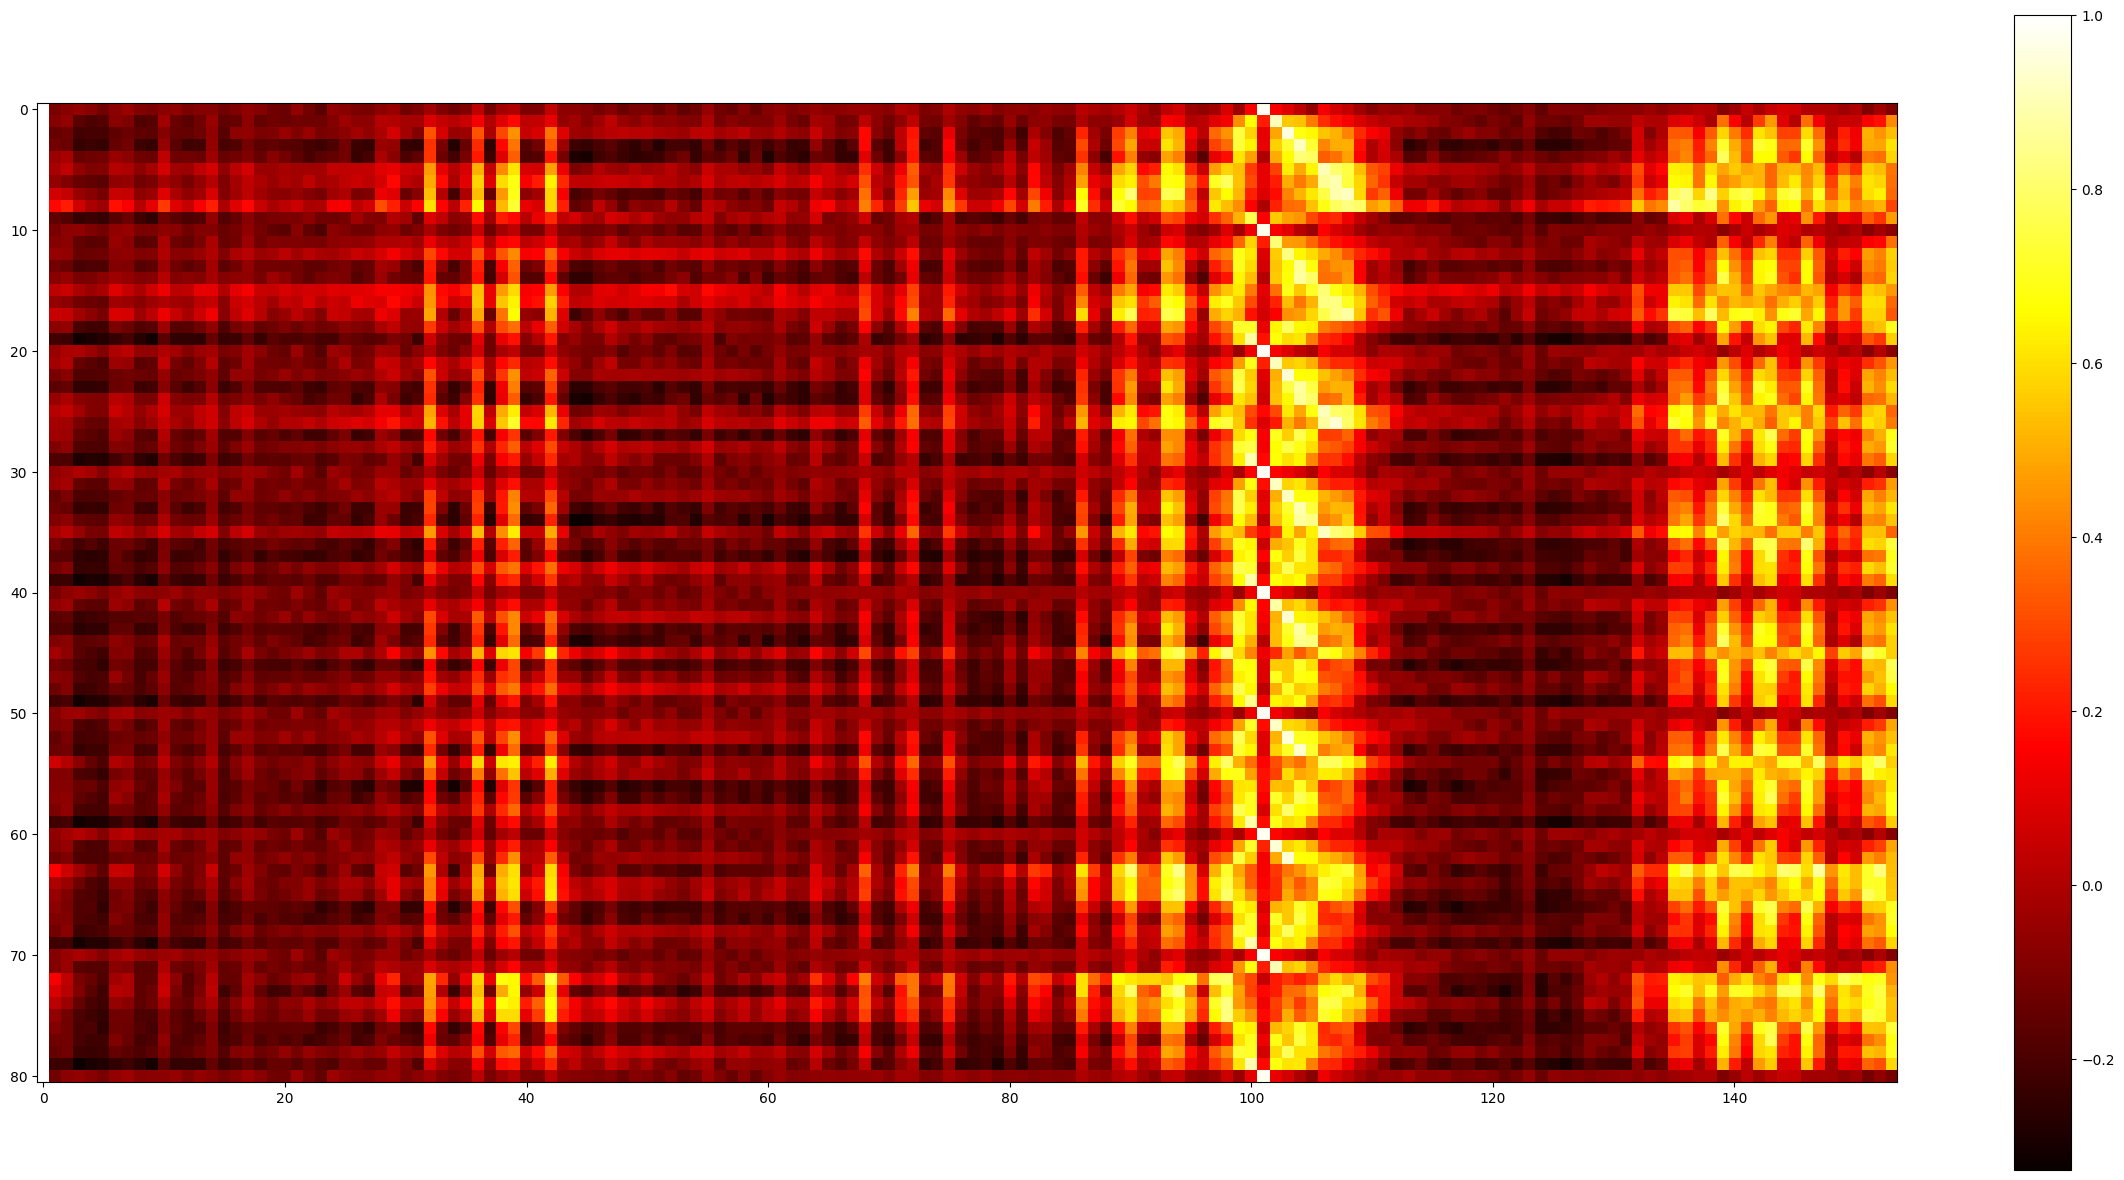

In [61]:
plot.heatmap2d(
    als.cossim(
        np.vstack(als.slice_of_slice(pair_emb1, (67,76), (67,76)).reshape((-1, 128))), 
        pair_emb2[100]
    ), scale=3
)

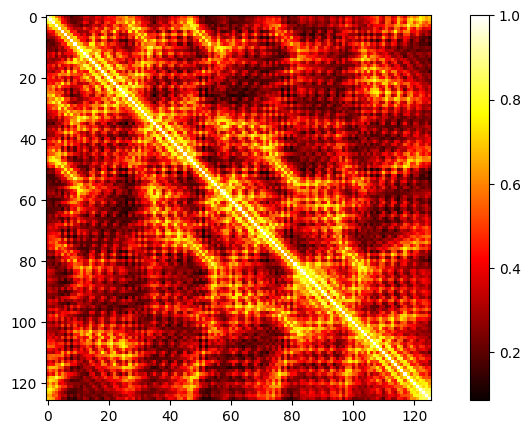

In [74]:
plot.heatmap2d(np.mean(pair_emb1_dist, axis=0))

## Dimentionality reduction (PCA, t-SNE)

In [162]:
tsne_result1 = als.tsne(als.pca(pair_emb1[22], components=16), components=2)
tsne_result2 = als.tsne(als.pca(pair_emb2[40], components=16), components=2)

Shape: (126, 16)
Explained variation per principal component: [0.3381749  0.19780344 0.12710077 0.06036497 0.04602256 0.03978152
 0.02649749 0.02485225 0.01578548 0.01247658 0.01151379 0.00911944
 0.00778596 0.00685847 0.00656458 0.00579454]
Cumulative explained variation for 16 principal components: 0.9364967346191406
Shape: (208, 16)
Explained variation per principal component: [0.35613742 0.16311449 0.1164519  0.08286921 0.04941927 0.04280133
 0.02900593 0.024602   0.01387893 0.01233443 0.01081256 0.00872059
 0.00740469 0.00690925 0.0060157  0.00519811]
Cumulative explained variation for 16 principal components: 0.9356757998466492


In [ ]:
plot.scatter2d(tsne_result1)

In [ ]:
plot.scatter2d(tsne_result2)

In [259]:
tsne_result1 = als.tsne(als.pca(emb1, components=32), components=3)
tsne_result2 = als.tsne(als.pca(emb2, components=32), components=3)

Shape: (157, 32)
Explained variation per principal component: [0.28824082 0.05851466 0.04124964 0.03781538 0.03367277 0.0320163
 0.03054459 0.0268756  0.02469257 0.02233062 0.01952435 0.01789849
 0.01552027 0.01505934 0.0147131  0.01382911 0.01288183 0.01156624
 0.01113194 0.01032007 0.01006917 0.00963788 0.00934143 0.00868344
 0.00818346 0.00783152 0.00747429 0.00698503 0.00685893 0.00615919
 0.00594845 0.00568029]
Cumulative explained variation for 32 principal components: 0.8312507271766663
Shape: (153, 32)
Explained variation per principal component: [0.2639764  0.05358095 0.05035974 0.04085959 0.0362499  0.03388963
 0.03261468 0.03020408 0.02358498 0.02179906 0.02057957 0.01796296
 0.01662023 0.01630591 0.01571791 0.0154122  0.01386285 0.01178916
 0.01175212 0.01080732 0.01006386 0.00974999 0.00938236 0.00853395
 0.00806321 0.00771613 0.00736495 0.00685982 0.00644941 0.00634072
 0.00626116 0.00597212]
Cumulative explained variation for 32 principal components: 0.8306869268417358
